In [ ]:
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

!pip install spacy
!pip install pandas

# Download the spaCy model
!python -m spacy download en_core_web_sm

In [79]:
#Importing Libraries
import numpy as np
import pandas as pd

In [80]:
data = pd.read_csv('dataset/2022.csv')
df = pd.DataFrame(data)

In [81]:
df.head()

,Date,ProductName,TagLine,Topic,Comments,Upvotes,ShortUrl,PricingType
0,2022-01-01,World Explorer by Insured Nomads,Insurance meets travel tech for the global wor...,Global Nomad,84,388,https://www.producthunt.com/r/p/325054,NaN
1,2022-01-01,Tailwind Box Shadows,Curated list of box shadows for your cards to ...,Productivity,25,201,https://www.producthunt.com/r/p/325075,Free
2,2022-01-01,24me Smart Personal Assistant,Keep new year's resolutions and get organized ...,Productivity,8,126,https://www.producthunt.com/r/p/325088,Free
3,2022-01-01,Habitify Challenge,Track & build new habits with your friends in ...,Productivity,10,167,https://www.producthunt.com/r/p/325066,Free
4,2022-01-01,Sunflower iOS App,Rewire your brain to associate sobriety with r...,iOS,14,105,https://www.producthunt.com/r/p/324724,Free


# Preprocessing & Exploratory Data Analysis (EDA)

In [82]:
df.shape

(10661, 8)

In [83]:
df.isnull().sum()

Date             0
ProductName      0
TagLine          0
Topic            0
Comments         0
Upvotes          0
ShortUrl         0
PricingType    153
dtype: int64

In [84]:
df = df.drop(columns=['PricingType', 'ShortUrl'])

In [85]:
df

,Date,ProductName,TagLine,Topic,Comments,Upvotes
0,2022-01-01,World Explorer by Insured Nomads,Insurance meets travel tech for the global wor...,Global Nomad,84,388
1,2022-01-01,Tailwind Box Shadows,Curated list of box shadows for your cards to ...,Productivity,25,201
2,2022-01-01,24me Smart Personal Assistant,Keep new year's resolutions and get organized ...,Productivity,8,126
3,2022-01-01,Habitify Challenge,Track & build new habits with your friends in ...,Productivity,10,167
4,2022-01-01,Sunflower iOS App,Rewire your brain to associate sobriety with r...,iOS,14,105
...,...,...,...,...,...,...
10656,2022-12-31,Cloud Rebels,IT has never been easier,Tech,1,25
10657,2022-12-31,SuenaGringo AI,Helps Spanish immigrants write natural & engag...,Productivity,5,24
10658,2022-12-31,Gmax CRM Open Source,Gmax CRM is an open source invoicing software,Productivity,1,23
10659,2022-12-31,Grocery Delivery App Development,SpotnEats developing customized apps for you,Productivity,2,18


In [86]:
num_products = df['ProductName'].nunique()
num_topic = df['Topic'].nunique()
print(f"Number of unique products: {num_products}")
print(f"Number of unique topics: {num_topic}")

Number of unique products: 10544
Number of unique topics: 258


In [87]:
df.dtypes

Date           object
ProductName    object
TagLine        object
Topic          object
Comments        int64
Upvotes        object
dtype: object

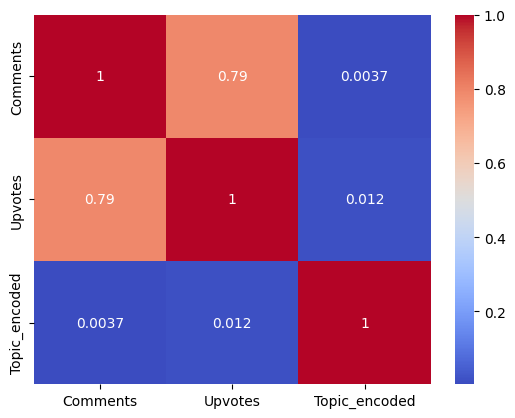

In [88]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Convert 'Upvotes' to numeric (if necessary)
df['Upvotes'] = pd.to_numeric(df['Upvotes'], errors='coerce')

# Encode 'Topic' using LabelEncoder
label_encoder = LabelEncoder()
df['Topic_encoded'] = label_encoder.fit_transform(df['Topic'])

# Select numeric columns including the encoded 'Topic'
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

In [89]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load the spacy model
nlp = spacy.load("en_core_web_sm")

def extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

df['Tags'] = df['TagLine'].apply(extract_tags)



In [90]:
# Rating Based recommendation
# Calculate rating
df['Rating'] = df['Upvotes'] + 0.5 * df['Comments']

In [91]:
def get_top_rated_items(df, topic, top_n=3):
    # Group by 'ProductName', 'TagLine', and 'Topic', then calculate the mean rating
    average_rating = df.groupby(['ProductName', 'TagLine', 'Topic'])['Rating'].mean().reset_index()
    
    # Filter the DataFrame by the specified topic
    filtered_df = average_rating[average_rating['Topic'] == topic]
    
    # Sort the filtered DataFrame by rating in descending order
    sorted_df = filtered_df.sort_values(by='Rating', ascending=False)
    
    # Return the top N items
    return sorted_df.head(top_n)

# Example usage:
# top_items = get_top_rated_items(df, 'iOS')
# print(top_items)

In [124]:
# Content Based recommendation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class ProductRecommender:
    def __init__(self, df):
        self.df = df
        self.tfidf_matrix, self.cosine_similarities = self._compute_similarities()

    def _compute_similarities(self):
        # Concatenate relevant columns into a single text column for TF-IDF vectorization
        self.df['combined_text'] = (self.df['Date'].astype(str) + ' ' +
                                    self.df['ProductName'] + ' ' +
                                    self.df['TagLine'] + ' ' +
                                    self.df['Topic'] + ' ' +
                                    self.df['Tags'])

        # TF-IDF vectorization
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf_vectorizer.fit_transform(self.df['combined_text'])

        # Compute cosine similarities
        cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

        return tfidf_matrix, cosine_similarities

    def recommend_similar_products(self, product_name, top_n=10):
        # Check if the product name exists in the DataFrame
        if product_name not in self.df['ProductName'].values:
            return f"Product '{product_name}' not found in the DataFrame."

        # Find the product index for the given product name
        product_index = self.df[self.df['ProductName'] == product_name].index[0]

        # Get top similar products
        similar_products = sorted(list(enumerate(self.cosine_similarities[product_index])),
                                  key=lambda x: x[1], reverse=True)
        top_similar_products = similar_products[1:top_n+1]  # Exclude the product itself
        recommend_products_index = [x[0] for x in top_similar_products]

        return self.df.iloc[recommend_products_index][['ProductName', 'Topic']]

# Initialize the recommender system
recommender = ProductRecommender(df)

In [125]:
# Example usage
product_name = 'Tailwind Box Shadows'
top_similar_products = recommender.recommend_similar_products(product_name)
print(top_similar_products)

                   ProductName            Topic
4547          Gradient Shadows  Developer Tools
195                 AddShadows     Design Tools
808    Mystery Box - Evolution          Android
1630                 DevAssets     Productivity
7887             Bored Box B64            Games
10650   AI Radar for Marketing     Productivity
6532          Keyframes.app v2  Developer Tools
4193              Stand Up Log     Productivity
10449                 gpt-List     Productivity
4669     Notion Resources List     Productivity
